<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [18]:
pip install -U kaleido

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 MB 25.0 kB/s eta 0:00:0000:0101:38��━ 58.4/85.2 MB 30.4 kB/s eta 0:14:42
You should consider upgrading via the '/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


Загрузим библиотеки

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio



import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

Откроем файл

In [4]:
df_1 = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [5]:
df_1.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Подготовим данные

In [6]:
data = df_1.resample('1H').sum()
print(data.head())
print(data.tail())
print('')
print('Начало периода ', data.index.min(), 'конец периода ', data.index.max())
print('Продолжительность ', data.index.max() - data.index.min())

                     num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43
                     num_orders
datetime                       
2018-08-31 19:00:00         136
2018-08-31 20:00:00         154
2018-08-31 21:00:00         159
2018-08-31 22:00:00         223
2018-08-31 23:00:00         205

Начало периода  2018-03-01 00:00:00 конец периода  2018-08-31 23:00:00
Продолжительность  183 days 23:00:00


## Анализ

Посмотрим на статистические характеристики

In [7]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


In [8]:
decomposed = seasonal_decompose(data)

Рассмотрим трендовые и сезонные составляющие 

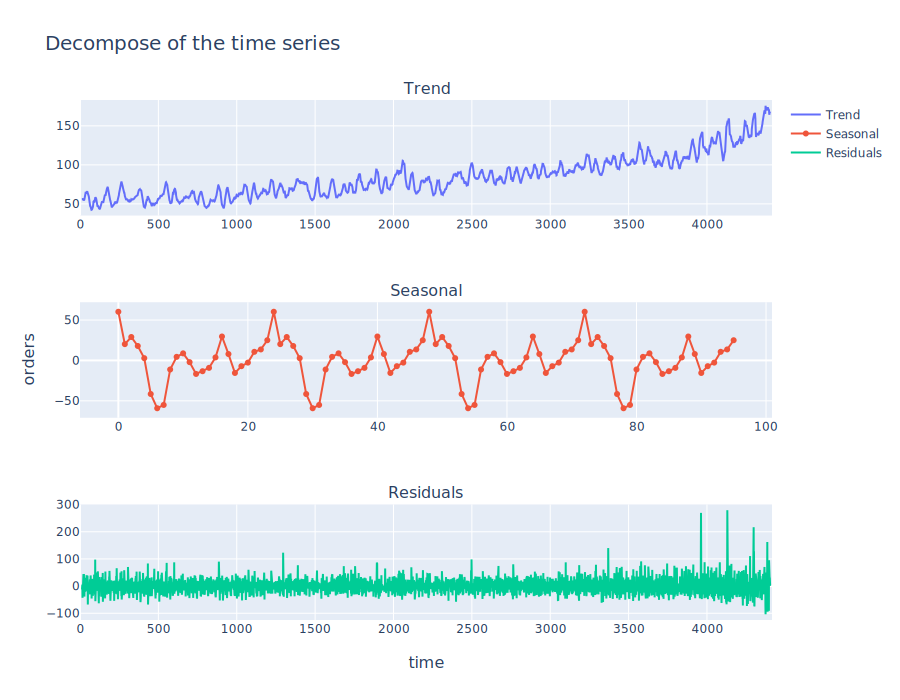

In [9]:
pio.renderers.default = "svg" # only for GitHub, comment for Plotly's interactive 

fig = make_subplots(
    rows=3, cols=1,
    row_heights=[1, 1, 1],
    subplot_titles=('Trend',  'Seasonal', 'Residuals'),
    x_title=('time'),
    y_title=('orders')
    
)


fig.add_trace(go.Scatter(y = decomposed.trend,
                    mode='lines',    
                    name="Trend"), row=1, col=1)
fig.add_trace(go.Scatter(y=decomposed.seasonal[:96],
                    mode='lines+markers',
                    name='Seasonal'), row=2, col=1)
fig.add_trace(go.Scatter(y=decomposed.resid,
                    mode='lines', 
                    name='Residuals'), row=3, col=1)


fig.update_layout(
    autosize=False,
    width=900,
    height=700,
    title_text="Decompose of the time series",
    title_font_size=20
)


fig.show()

Вывод: видим выраженый тренд, заказов становится больше. Сезонность также прослеживается, каждые 24 часа.

## Обучение

Разделим датасет на обучающую и тестовую выборки

In [10]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)

print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-01 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


In [11]:
print("Среднее количество заказов в час:", test['num_orders'].mean())

pred_median = np.ones(test.shape) * train['num_orders'].median()

print("RMSE:", mean_squared_error(test, pred_median) ** 0.5)

Среднее количество заказов в час: 139.55656108597285
RMSE: 87.15277582981295


Оценим модель предыдущим значением ряда

In [12]:
pred_previous = np.ones(test.shape) * test.shift().fillna(train.iloc[len(train)-1])
print("RMSE:", mean_squared_error(test, pred_previous) ** 0.5)

RMSE: 58.856486242815066


При таком прогнозе модель ошибается меньше. Проверка на адекватность есть.

Добавим функцию для описания признаков

In [13]:
def make_features(df, max_lag, rolling_mean_size):    
    df_new = df.copy(deep=True)
    df_new['year'] = df_new.index.year
    df_new['month'] = df_new.index.month
    df_new['day'] = df_new.index.day
    df_new['dayofweek'] = df_new.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df_new['lag_{}'.format(lag)] = df_new['num_orders'].shift(lag)

    df_new['rolling_mean'] = df_new['num_orders'].shift().rolling(rolling_mean_size).mean()
    return df_new

Обучим модель на полученных признаках

In [14]:
data_feature = make_features(data, 48, 36)

train, test = train_test_split(data_feature, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop('num_orders', axis = 1)
target_train = train['num_orders']

features_test = test.drop('num_orders', axis = 1)
target_test = test['num_orders']


Добавим метрику

In [15]:
mse = make_scorer(mean_squared_error, greater_is_better=False)

###  LinearRegression

Подберем гиперпараметры модели с помощью GridSearchCV

In [16]:
model = LinearRegression()
parameters = {'fit_intercept':[True,False], 
              'normalize':[True,False], 
              'copy_X':[True, False]
             }
grid = GridSearchCV(model,parameters, cv=TimeSeriesSplit(3), scoring=mse)
grid.fit(features_train, target_train)
print("best score: ", (-grid.best_score_)** 0.5, "best parameters", grid.best_params_)

best score:  25.388218979022163 best parameters {'copy_X': True, 'fit_intercept': False, 'normalize': True}


In [17]:
model_lr = grid.best_estimator_
model_lr.fit(features_train, target_train)
pred_train = model_lr.predict(features_train)

print("RMSE обучающей выборки:", mean_squared_error(target_train, pred_train)** 0.5)


RMSE обучающей выборки: 23.347323316371693


### RandomForestRegressor

Подберем гиперпараметры модели с помощью GridSearchCV

In [18]:
%%time
1 + 1
model = RandomForestRegressor()
parameters = {'n_estimators':[1,60],
              'max_depth':[1,5]
             }
grid = GridSearchCV(model,parameters, cv=TimeSeriesSplit(5), scoring = mse)
grid.fit(features_train, target_train)
print("best score: ", (grid.best_score_)** 0.5, "best parameters", grid.best_params_)

best score:  nan best parameters {'max_depth': 5, 'n_estimators': 60}
CPU times: user 12.7 s, sys: 273 ms, total: 12.9 s
Wall time: 18.5 s


<timed exec>:8: RuntimeWarning:

invalid value encountered in double_scalars



In [19]:
model_dfr = grid.best_estimator_
model_dfr.fit(features_train, target_train)
pred_train = model_dfr.predict(features_train)

print("RMSE обучающей выборки:", mean_squared_error(target_train, pred_train)** 0.5)


RMSE обучающей выборки: 22.379110965015105


### CatBoostRegressor

Подберем гиперпараметры модели с помощью GridSearchCV

In [20]:
    model = CatBoostRegressor()
    parameters = {'depth'         : [6, 8],
                  'learning_rate' : [0.01, 0.5, 0.1, 1],
                  'iterations'    : [30, 50, 100]
                 }
    grid = GridSearchCV(estimator=model, param_grid = parameters, cv = TimeSeriesSplit(5), n_jobs=-1)
    grid.fit(features_train, target_train)    

    # Results from Grid Search
    print("\n========================================================")
    print(" Results from Grid Search " )
    print("========================================================")    
    
    print("\n The best estimator across ALL searched params:\n",
          grid.best_estimator_)
    
    print("\n The best score across ALL searched params:\n",
          grid.best_score_)
    
    print("\n The best parameters across ALL searched params:\n",
          grid.best_params_)
    
    print("\n ========================================================")

0:	learn: 36.7934623	total: 69.3ms	remaining: 6.86s
1:	learn: 35.2501306	total: 83.1ms	remaining: 4.07s
2:	learn: 33.7902741	total: 93.9ms	remaining: 3.04s
3:	learn: 32.4814083	total: 102ms	remaining: 2.46s
4:	learn: 31.3617581	total: 116ms	remaining: 2.2s
5:	learn: 30.3490452	total: 131ms	remaining: 2.05s
6:	learn: 29.5380359	total: 140ms	remaining: 1.86s
7:	learn: 28.7621897	total: 148ms	remaining: 1.71s
8:	learn: 28.0937413	total: 157ms	remaining: 1.58s
9:	learn: 27.4814534	total: 164ms	remaining: 1.48s
10:	learn: 26.9778684	total: 172ms	remaining: 1.39s
11:	learn: 26.5374281	total: 178ms	remaining: 1.31s
12:	learn: 26.1247462	total: 186ms	remaining: 1.24s
13:	learn: 25.8061275	total: 193ms	remaining: 1.18s
14:	learn: 25.4361860	total: 200ms	remaining: 1.13s
15:	learn: 25.1230254	total: 206ms	remaining: 1.08s
16:	learn: 24.8416326	total: 215ms	remaining: 1.05s
17:	learn: 24.6276255	total: 222ms	remaining: 1.01s
18:	learn: 24.4290419	total: 229ms	remaining: 975ms
19:	learn: 24.251898

In [21]:
model_cb = grid.best_estimator_
model_cb.fit(features_train, target_train)
pred_train = model_cb.predict(features_train)

print("RMSE обучающей выборки:", mean_squared_error(target_train, pred_train)** 0.5)

0:	learn: 36.7934623	total: 38.3ms	remaining: 3.79s
1:	learn: 35.2501306	total: 48.8ms	remaining: 2.39s
2:	learn: 33.7902741	total: 59ms	remaining: 1.91s
3:	learn: 32.4814083	total: 71.2ms	remaining: 1.71s
4:	learn: 31.3617581	total: 87.5ms	remaining: 1.66s
5:	learn: 30.3490452	total: 98.8ms	remaining: 1.55s
6:	learn: 29.5380359	total: 106ms	remaining: 1.41s
7:	learn: 28.7621897	total: 114ms	remaining: 1.31s
8:	learn: 28.0937413	total: 121ms	remaining: 1.22s
9:	learn: 27.4814534	total: 134ms	remaining: 1.2s
10:	learn: 26.9778684	total: 140ms	remaining: 1.14s
11:	learn: 26.5374281	total: 150ms	remaining: 1.1s
12:	learn: 26.1247462	total: 161ms	remaining: 1.07s
13:	learn: 25.8061275	total: 167ms	remaining: 1.03s
14:	learn: 25.4361860	total: 174ms	remaining: 988ms
15:	learn: 25.1230254	total: 182ms	remaining: 954ms
16:	learn: 24.8416326	total: 188ms	remaining: 918ms
17:	learn: 24.6276255	total: 194ms	remaining: 885ms
18:	learn: 24.4290419	total: 201ms	remaining: 855ms
19:	learn: 24.251898

    Лучший результат показала модель CatBoost

## Тестирование

In [22]:
pred_test_lr = model_lr.predict(features_test)
print("RMSE тестовой выборки: ", mean_squared_error(target_test, pred_test_lr)** 0.5)

RMSE тестовой выборки:  43.15670563722789


In [23]:
pred_test_dfr = model_dfr.predict(features_test)
print("RMSE тестовой выборки: ", mean_squared_error(target_test, pred_test_dfr)** 0.5)

RMSE тестовой выборки:  43.86601355407549


In [24]:
pred_test_cb = model_cb.predict(features_test)
print("RMSE тестовой выборки: ", mean_squared_error(target_test, pred_test_cb)** 0.5)

RMSE тестовой выборки:  41.38528637621573


На тестовых данных модель catboost также показала лучший результат

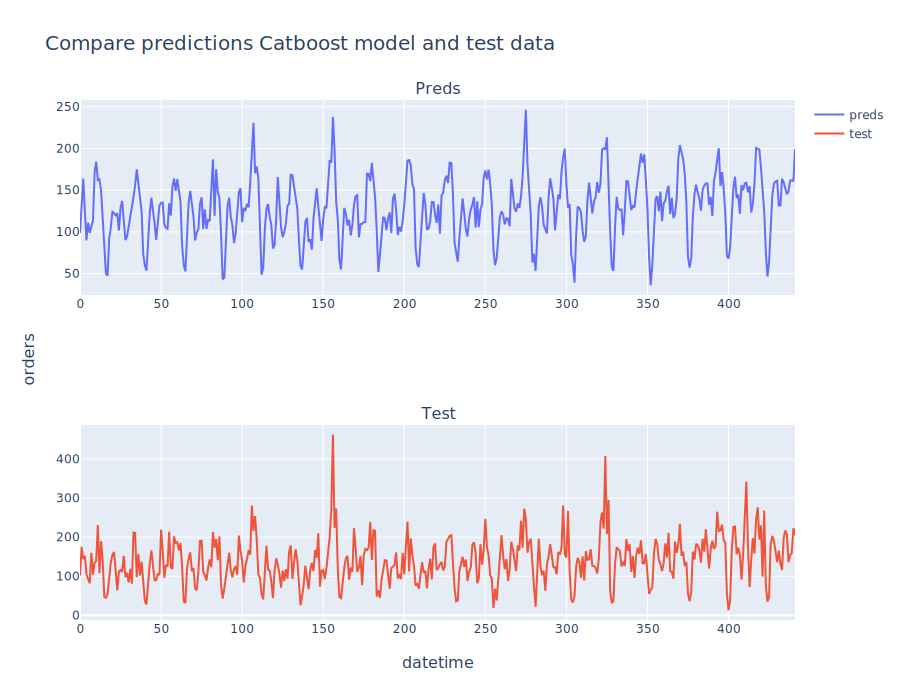

In [25]:
fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=('Preds',  'Test'),
    x_title=('datetime'),
    y_title=('orders')
    
)

fig.add_trace(go.Scatter(y = pred_test_cb,
                    mode='lines',    
                    name="preds"), row=1, col=1)
fig.add_trace(go.Scatter(y=target_test,
                    mode='lines',
                    name='test'), row=2, col=1)

fig.update_layout(
    autosize=False,
    width=900,
    height=700,
    title_text="Compare predictions Catboost model and test data",
    title_font_size=20
)

fig.show()

Визуализируем предсказания моделей CB и DFR в сравнении с тестовыми данными

In [26]:
df_compare = pd.DataFrame(target_test.reset_index())
df_compare.columns = ['datetime','num_orders_test']
df_compare['num_orders_preds_cb'] = pd.Series(pred_test_cb)
df_compare['num_orders_preds_dfr'] = pd.Series(pred_test_dfr)
df_compare.index = df_compare.datetime
df_compare = df_compare.drop('datetime', axis = 1)

In [27]:
df_compare.head()

,num_orders_test,num_orders_preds_cb,num_orders_preds_dfr
datetime,,,
2018-08-13 14:00:00,102,98.793605,96.890178
2018-08-13 15:00:00,175,136.541801,132.628715
2018-08-13 16:00:00,144,163.625348,142.418339
2018-08-13 17:00:00,152,124.789052,131.632840
2018-08-13 18:00:00,104,89.834212,82.281539


Отобразим результаты на одном графике

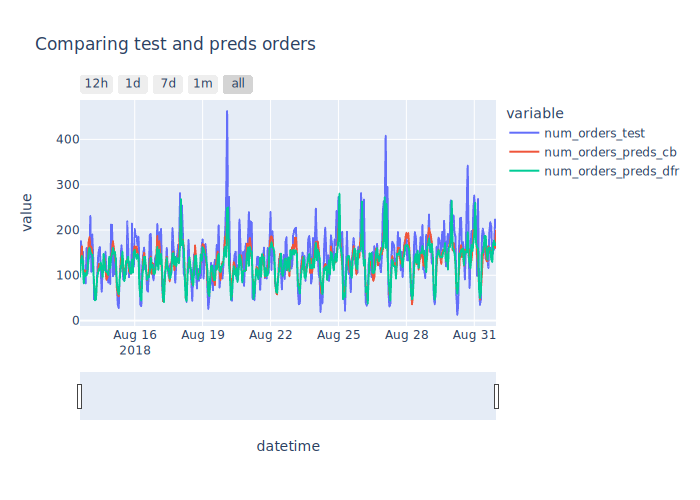

In [28]:
fig = px.line(df_compare, y=df_compare.columns,
              title='Comparing test and preds orders')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=12, label="12h", step="hour", stepmode="todate"),
            dict(count=1, label="1d", step="day", stepmode="backward"),
            dict(count=7, label="7d", step="day", stepmode="backward"),
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(step="all")
        ])
    )
)

fig.show()

Вывод: загрузили, подготовили и проанализировали данные. Обучили модель, подобрав гиперпараметры.  Качество моделей проверено. Значение RMSE на тестовой выборке не больше 48, что удовлетворяет требованиям заказчика.